# Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms

In this document, we are replicating the work by S.Sim,P.D.Johnson and A.Aspuru-Guzik *Adv.Quantum.Technol.* **2** 1900070 (2019): https://arxiv.org/abs/1905.10876

Consider a parameterized quantum circuit $U(\mathbf{x})$, and define the quantity
$$f(\mathbf{x},\mathbf{y}) = |\langle 0 | U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}$$
This quantity is the fidelity of the two states
$$\begin{align*}
|\psi_{\mathbf{x}}\rangle = U(\mathbf{x})|0\rangle~~&\text{and}~~|\psi_{\mathbf{y}}\rangle = U(\mathbf{y})|0\rangle:\\
|\langle \psi_{\mathbf{y}}|\psi_{\mathbf{x}}\rangle|^{2} &= |\langle 0 |U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}.
\end{align*}$$

Suppose we generate a bunch of random realizations of $\mathbf{x},\mathbf{y}$. This gives us a set of random realizations of $f$; let's call that set $F = \{f_{1}, f_{2}, \cdots \}$.

To calculate the expressibility, we need to do 2 things:
* Generate a _histogram_ of the elements of $F$. The output of this histogram is a set of bins $B = \{(l_1, u_1), (l_2, u_2), \cdots \}$ where $l_{j}$ ($u_j$) denotes the lower (upper) limit of bin $j$. It also produces an empirical probability distribution function $\mathrm{Pr}_{\text{emp}}(j)$, which is simply the probability that a given value of $f$ falls in a bin $j$.
* Given the bins of the histogram, we need to compute the probability that a given fidelity value would fall into bin $j$ if the circuit generating that fidelity is drawn from a Haar-random distribution. If the circuit acts on $n$ qubits, the probability of a given fidelity value $f$ is:
$$ \mathrm{Pr}_{\text{Haar}}(f) = (N -1)*(1-f)^{N-2}~~N=2^{n}.$$
To calculate the probability over a bin of the histogram, we do an integral:
$$\mathrm{Pr}_{\text{Haar}}(j) = \int_{l_{j}}^{u_{j}}  \mathrm{Pr}_{\text{Haar}}(f) ~df =  (1-l_{j})^{N-1}  - (1-u_{j})^{N-1}$$
The expressibility is then estimated as the KL divergence between the empirically-observed probability distribution (i.e., the histogram) and the probability distribution that would result under a Haar-random unitary.
$$\text{Expr} = \mathrm{KL}(\mathrm{Pr}_{\text{emp}}|| \mathrm{Pr}_{\text{Haar}}) = \sum_{j} \mathrm{Pr}_{\text{emp}}(j)\log\left(\frac{\mathrm{Pr}_{\text{emp}}(j)}{\mathrm{Pr}_{\text{Haar}}(j)}\right)$$

$x$

In [73]:
from matplotlib import pyplot
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute,assemble,QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.extensions import *

from qiskit.quantum_info import random_unitary

import matplotlib.pyplot as plt
from qiskit.circuit import Parameter,ControlledGate

%matplotlib inline
import numpy as np
import math
from math import pi, sqrt

from scipy.special import rel_entr
from random import seed
from random import random
import cmath

In [74]:

#Possible Bin
bins_list=[];
for i in range(76):
    bins_list.append((i)/75)
#Center of the Bean
bins_x=[]    
for i in range(75):
    bins_x.append(bins_list[1]+bins_list[i])
def P_harr(l,u,N):
    return (1-l)**(N-1)-(1-u)**(N-1)
#Harr historgram
P_harr_hist=[]
for i in range(75):
    P_harr_hist.append(P_harr(bins_list[i],bins_list[i+1],2))    
#Imaginary    
j=(-1)**(1/2)

print (P_harr_hist)

## Idle Circuit

In [75]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=10000
nparam=4000
fidelity=[]    
for x in range(nparam):
    th=2*pi*random()
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)
    qc.i(qr[0])
    qc.i(qr[0])
    qc.measure(qr[0],cr[0])
    job = execute(qc, backend, shots=nshot)
    result = job.result()
    count =result.get_counts()

    if '0' in count:
        ratio=count['0']/nshot
    else:
        ratio=0
    fidelity.append(ratio)


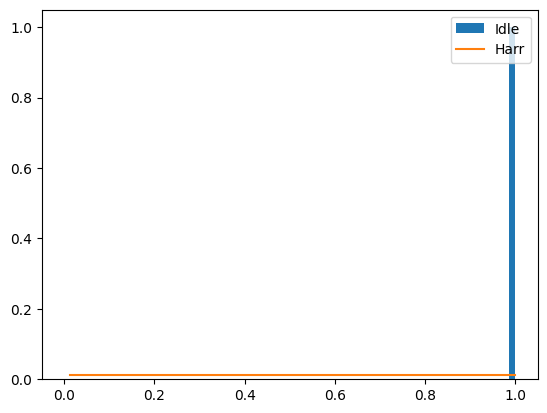

In [76]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Idle', range=[0, 1])
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [77]:
# example of calculating the kl divergence (relative entropy) with scipy
P_I_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 4.317 nats


In [78]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qr = QuantumRegister(n_qubits)
        self.cr = ClassicalRegister(1)

        self.qc = QuantumCircuit(self.qr, self.cr)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k)) for k in range(self.n_qubits)}

        self.qc.h(0)
        self.qc.cx(1, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 2)

        self.qc.barrier()

        for k in range(0, 4):
            self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(3, 2)
        self.qc.cx(2, 1)
        self.qc.cx(1, 0)
        self.qc.h(0)

        self.qc.measure(self.qr[0], self.cr[0])
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)

    def run(self, params):
        parameters = {}

        for k in range(self.n_qubits):
          parameters[self.thetas[k]] = params[k]

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        return job.result().get_counts()

## Circuit A

In [79]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=3000
nparam=4000
QC = QCNeuron(4, backend, nshot)

fidelity=[]    
for x in range(nparam):
    if x%500 == 0:
        print ('round ', x+1)
    th1=2*pi*random()
    th2=2*pi*random()
    th3=2*pi*random()
    th4=2*pi*random()
    
    count =QC.run([th1, th2, th3, th4])
    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0

    
    fidelity.append(ratio)


round  1


/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_70247/2085690804.py:45: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


round  501
round  1001
round  1501
round  2001
round  2501
round  3001
round  3501


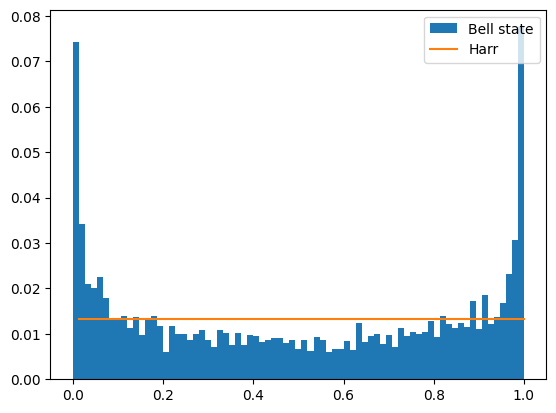

In [80]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Bell state')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [81]:
#Kullback Leibler divergence
P_A_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_A_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.215 nats


In [82]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qr = QuantumRegister(n_qubits)
        self.cr = ClassicalRegister(1)
        self.n_qubits = n_qubits

        self.qc = QuantumCircuit(self.qr, self.cr)
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}

        all_qubits = [i for i in range(n_qubits)]
        self.qc.h(all_qubits)
        self.qc.barrier()

        for k in range(0, 4):
          self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(1, 0)
        self.qc.cx(2, 0)
        self.qc.cx(3, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 1)
        self.qc.cx(3, 2)
        self.qc.barrier()

        for k in range(0, 4):
          self.qc.ry(self.thetas[k+4], k)

        self.qc.measure(self.qr[0], self.cr[0])
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)

    def run(self, params):
        parameters = {}

        for k in range(2*self.n_qubits):
          parameters[self.thetas[k]] = params[k]

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        return job.result().get_counts()

In [83]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
backend = QasmSimulator(method='matrix_product_state')

nshot=3000
nparam=4000
QC = QCNeuron(4, backend, nshot)

fidelity=[]    
for x in range(nparam):
    if x%500 == 0:
        print ('round ', x+1)

    th1=2*pi*random()
    th2=2*pi*random()
    th3=2*pi*random()
    th4=2*pi*random()
    th5=2*pi*random()
    th6=2*pi*random()
    th7=2*pi*random()
    th8=2*pi*random()
    
    count =QC.run([th1, th2, th3, th4, th5, th6, th7, th8])
    
    if '0' in count and '1' in count:
        ratio=count['0']/nshot
    elif '0' in count and '1' not in count:
        ratio=count['0']/nshot
    else:
        ratio=0

    
    fidelity.append(ratio)


round  1


/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_70247/1164067958.py:48: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


round  501
round  1001
round  1501
round  2001
round  2501
round  3001
round  3501


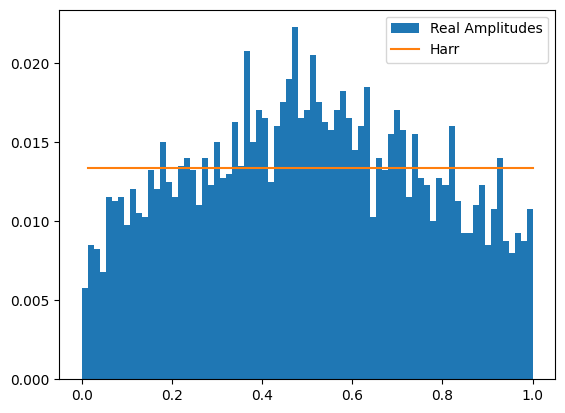

In [84]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, label='Real Amplitudes')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.legend(loc='upper right')
plt.show()

In [85]:
#Kullback Leibler divergence
P_A_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_A_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.033 nats
